In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
import matplotlib 
matplotlib.rc_file_defaults()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
params = {'xtick.labelsize': 10, 'ytick.labelsize': 10}
matplotlib.rcParams.update(params)
import datetime
pd.set_option('display.max_columns', None)

In [65]:
# Cargamos los datos
file_stats = "SQMStats_Pangamos_20210830-20220203v3.xlsx"
df = pd.read_excel(file_stats)
df_mop = df[(df["Producto"].notna()) & (df["Producto"].str.contains("MOP")) 
            & df["Hora Ingreso a Puerto"].notna() & df["Hora Legada a Espera"].notna()]
df_mop.shape

(3218, 32)

In [66]:
# Dejamos columnas importantes
cols = df_mop.columns
cols = cols[~cols.str.contains("Unnamed")]
cols

Index(['Flota', 'Patente', 'Tipo', 'N Guia', 'Fecha', 'Producto', 'Viaje',
       'Origen', 'Origen inicio', 'Origen salida', 'Destino',
       'Destino termino', 'Hora Legada a Espera', 'Tiempo Espera [minutos]',
       'Hora Ingreso a Puerto', 'Tiempo Total en Puerto',
       'Tiempo total Descarga', 'Nombre Cancha', 'Nombre Geo Espera Exterior'],
      dtype='object')

In [67]:
cols = ['Hora Legada a Espera','Hora Ingreso a Puerto']

In [68]:
df_mop = df_mop[cols]

In [69]:
df_mop.head(1)

,Hora Legada a Espera,Hora Ingreso a Puerto
0,20210830 19:44:12,20210831 08:29:21


In [70]:
# Transformamos fechas en formato datetime
df_mop["Hora Ingreso a Puerto"] = pd.to_datetime(df_mop["Hora Ingreso a Puerto"])
df_mop["Hora Legada a Espera"] = pd.to_datetime(df_mop["Hora Legada a Espera"])

In [71]:
df_mop.head(1)

,Hora Legada a Espera,Hora Ingreso a Puerto
0,2021-08-30 19:44:12,2021-08-31 08:29:21


In [72]:
# Definimos la funcion que nos dice si es un turno nocturno
def Nocturno(t):
    if t > datetime.time(23,0,0):
        return True
    elif t < datetime.time(8,0,0):
        return True
    else: 
        return False

In [73]:
def Fecha_Activa(t):
    if datetime.time(23,0,0) < t.time():
        return t.date()
    else:
        fecha = t - datetime.timedelta(1)
        return fecha.date()

In [74]:
# Agregamos la columna Turno Nocturno
df_mop["Turno Nocturno"] = df_mop["Hora Legada a Espera"].apply(lambda x: Nocturno(x.time()))

In [84]:
df_noct = df_mop

In [85]:
df_noct["Fecha en Puerto"] = df_noct["Hora Ingreso a Puerto"].apply(lambda x: x.date())

In [86]:
df_noct["Fecha Nocturna Activa"] = df_noct["Hora Ingreso a Puerto"].apply(lambda x: Fecha_Activa(x))

In [87]:
df_noct.head(1)

,Hora Legada a Espera,Hora Ingreso a Puerto,Turno Nocturno,Fecha en Puerto,Fecha Nocturna Activa
0,2021-08-30 19:44:12,2021-08-31 08:29:21,False,2021-08-31,2021-08-30


In [88]:
# Definimos la funcion que entrega si la descarga ocurre despues de las 8.30
def Descarga(te, tp):
    if te.time() < datetime.time(8,0,0):
        if tp.time() > datetime.time(8,30,0):
            return True
        else:
            return False
    else:
        if (tp.time() > datetime.time(8,30,0)) & (tp.time() < datetime.time(23,0,0)):
            return True
        else:
            return False

In [89]:
# Creamos una nueva columna que diga si ocurre la descarga en horario de puerto
df_noct["Descarga en Apertura"] = df_noct.apply(lambda x: Descarga(x["Hora Legada a Espera"], x["Hora Ingreso a Puerto"]), axis = 1)

In [90]:
df_noct["Ingreso Nocturno a Puerto"] = df_noct["Hora Ingreso a Puerto"].apply(lambda x: Nocturno(x.time()))

In [94]:
date_noct = df_noct["Fecha Nocturna Activa"][df_noct["Ingreso Nocturno a Puerto"] == True].unique()
date_noct

array([datetime.date(2021, 8, 31), datetime.date(2021, 9, 1),
       datetime.date(2021, 9, 2), datetime.date(2021, 9, 3),
       datetime.date(2021, 9, 4), datetime.date(2021, 9, 5),
       datetime.date(2021, 9, 6), datetime.date(2021, 9, 7),
       datetime.date(2021, 9, 8), datetime.date(2021, 9, 30),
       datetime.date(2021, 10, 1), datetime.date(2021, 10, 2),
       datetime.date(2021, 10, 3), datetime.date(2022, 1, 27),
       datetime.date(2022, 1, 28)], dtype=object)

In [105]:
df_noct[df_noct["Ingreso Nocturno a Puerto"]==True].shape

(155, 7)

In [117]:
def Turno_Normal(te, tp):
    if (te.time() > datetime.time(8,0,0)) & (tp.time() < datetime.time(23,0,0)):
        return True
    else:
        return False

In [118]:
df_noct["Llegada e Ingreso en Turno"] = df_noct.apply(lambda x: Turno_Normal(x["Hora Legada a Espera"], x["Hora Ingreso a Puerto"]), axis = 1)

In [119]:
# Hacemos el conteo de camiones
N_apertura = []
for i in date_noct:
    a = df_noct[(df_noct["Descarga en Apertura"] == True) & 
                (df_noct["Fecha Nocturna Activa"] == i) &
                (df_noct["Llegada e Ingreso en Turno"] == False)]
    N_apertura.append(a.shape[0])
    
N_apertura = np.array(N_apertura)
N_apertura

array([10,  6,  8,  4,  2,  2,  6,  9,  0,  6,  3,  2,  4,  9,  6])

In [120]:
# Hacemos el conteo de camiones
N_noct = []
for i in date_noct:
    a = df_noct[(df_noct["Descarga en Apertura"] == False) & (df_noct["Fecha Nocturna Activa"] == i)]
    N_noct.append(a.shape[0])
    
N_noct = np.array(N_noct)
N_noct

array([12,  4,  4, 11, 12, 17, 16,  4,  2,  8, 10,  6,  9, 18, 28])

In [124]:
str_date = [str(i) for i in date_noct]

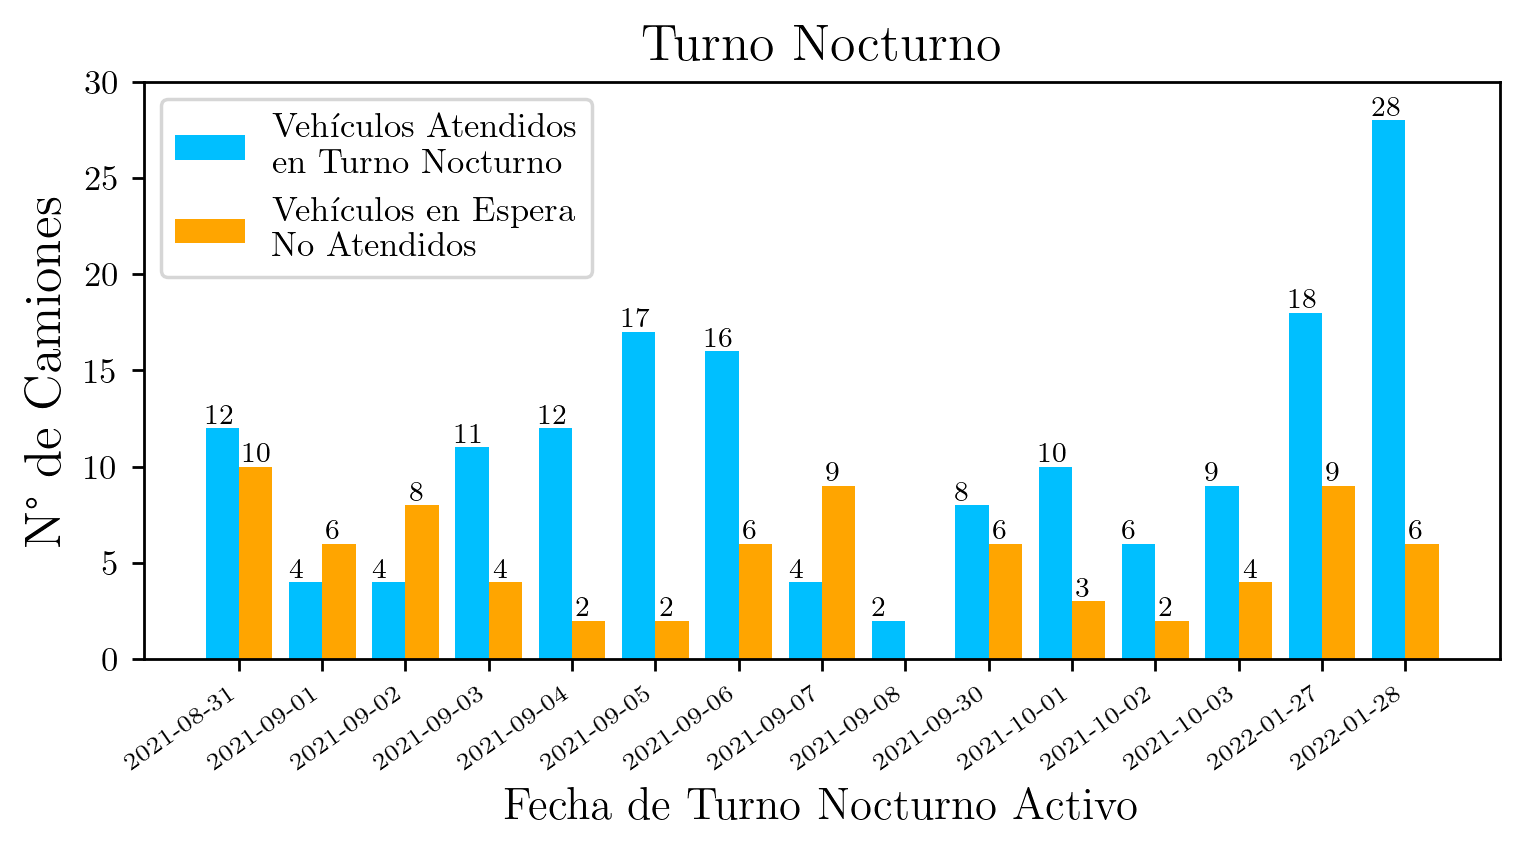

In [122]:
# Ploteamos

fig = plt.figure(figsize=(7,3), dpi = 250)

ax2 = fig.add_subplot(111)

idx = np.arange(len(str_date))
eps = 0.2
w = 0.4


idx_n = idx - eps
idx_a = idx + eps
ax2.bar(idx_n, N_noct, 
        label = "Vehículos Atendidos \n en Turno Nocturno", color = "deepskyblue", width=w)
ax2.bar(idx_a, N_apertura, 
        label = "Vehículos en Espera \n No Atendidos", color = "orange", width=w)
ax2.set_title("Turno Nocturno", fontsize = 15)
ax2.set_ylabel("N° de Camiones", fontsize = 15)

ax2.set_xticks(idx)
ax2.set_xticklabels(str_date, rotation = 35, fontsize = 7, 
                    fontdict = {"horizontalalignment": "right"}) 
ax2.set_xlabel("Fecha de Turno Nocturno Activo", fontsize = 13)
ax2.set_ylim([0,30])
ax2.legend(loc = "upper left")
#ax2.axhline(y = T_semana.mean(), c = "r", 
                #linestyle = "--", linewidth = 1, label = "Tiempo Promedio \n Semanal")


for i, label in enumerate(N_noct):
    if label != 0.:
        plt.annotate(str(round(label)), (idx_n[i] - 0.2, N_noct[i]+0.25), fontsize = 8)
        
for i, label in enumerate(N_apertura):
    if label != 0.:
        plt.annotate(str(round(label)), (idx_a[i] - 0.15, N_apertura[i]+0.25), fontsize = 8)

plt.savefig("Graficos/Camiones Atendidos en Turno Nocturno.png", bbox_inches= "tight")

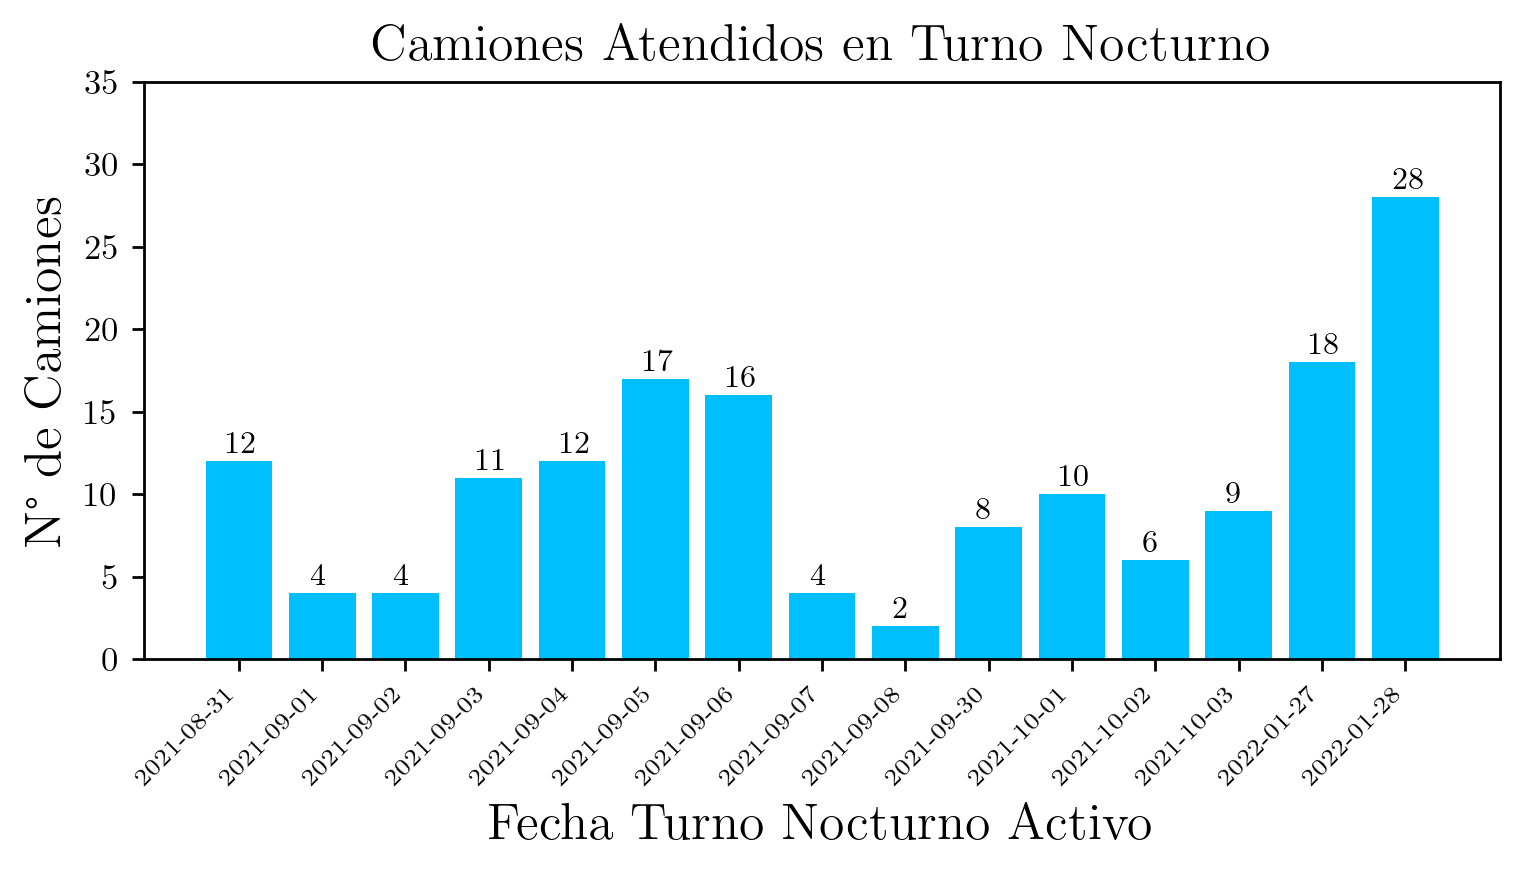

In [137]:
fig = plt.figure(figsize=(7,3), dpi = 250)

ax2 = fig.add_subplot(111)


ax2.bar(str_date, N_noct, color = "deepskyblue")
ax2.set_title("Camiones Atendidos en Turno Nocturno", fontsize = 15)
ax2.set_ylabel("N° de Camiones", fontsize = 15)

ax2.set_xticks(str_date)
ax2.set_xticklabels(str_date, rotation = 45, fontsize = 7, 
                    fontdict = {"horizontalalignment": "right"})
ax2.set_xlabel("Fecha Turno Nocturno Activo", fontsize = 15)
ax2.set_ylim([0,35])

for i, label in enumerate(N_noct):
        plt.annotate(str(round(label)), (i-0.15, label+.5), 
                     fontsize = 9, rotation = 0)

plt.savefig("Graficos/Camiones Atendidos en Turno Nocturno.png", bbox_inches= "tight")

In [101]:
fecha_nocturna = np.array([datetime.date(2021, 8, 31), datetime.date(2021, 9, 1),
       datetime.date(2021, 9, 2), datetime.date(2021, 9, 3),
       datetime.date(2021, 9, 4), datetime.date(2021, 9, 5),
       datetime.date(2021, 9, 6), datetime.date(2021, 9, 7),
       datetime.date(2021, 9, 8), datetime.date(2021, 9, 30),
       datetime.date(2021, 10, 1), datetime.date(2021, 10, 2),
       datetime.date(2021, 10, 3), datetime.date(2022, 1, 27),
       datetime.date(2022, 1, 28)])

In [138]:
N_noct.sum() + N_apertura.sum()

238